In [23]:
import numpy as np
import torch
import torch.nn as nn
import torch.nn.functional as F
from torch.utils.data import TensorDataset, DataLoader
from torchvision.datasets import FashionMNIST, MNIST, CIFAR10, SVHN
import torchvision
from torchvision import transforms
import torchvision.utils as vision_utils
import matplotlib.pyplot as plt
import math
import random
import os
import time

DEVICE = torch.device('cpu')

In [24]:
def switch_to_device(dataset,device=None):
    final_X, final_Y = [], []
    for x, y in dataset:
        final_X.append(x)
        final_Y.append(y)
    X = torch.stack(final_X)
    Y = torch.tensor(final_Y)
    if device is not None:
        X = X.to(device)
        Y = Y.to(device)
    return torch.utils.data.TensorDataset(X, Y)


def get_mnist_dl(batch_size_train=256, batch_size_eval=1024, device=torch.device('cpu')):
    transform = transforms.Compose([transforms.ToTensor()])
    
    data_train = MNIST('./datasets', train=True, download=True, transform=transform)
    data_train = switch_to_device(data_train, device=device)
    data_train, data_valid = torch.utils.data.random_split(data_train, [55000,5000])
    
    data_test = MNIST('./datasets', train=False, download=True, transform=transform)
    data_test = switch_to_device(data_test, device=device)
    
    train_dl = DataLoader(data_train, batch_size=batch_size_train, shuffle=True)
    valid_dl = DataLoader(data_valid, batch_size=batch_size_eval, shuffle=False)
    test_dl = DataLoader(data_test, batch_size=batch_size_eval, shuffle=False)
    
    return train_dl, valid_dl, test_dl

In [25]:
class LeNet(nn.Module):

  def __init__(self, num_classes=10) -> None:
    super().__init__()
    self.flatten = nn.Flatten()
    self.fc1 = nn.Linear(28*28, 1024)
    self.Relu1 = nn.Sigmoid()
    self.fc2 = nn.Linear(1024, 1024)
    self.Relu2 = nn.Sigmoid()
    self.fc3 = nn.Linear(1024, num_classes)
    #self.softmax = nn.Softmax()


  def forward(self, x: torch.Tensor) -> torch.Tensor:
    x = self.flatten(x)
    x = self.Relu1(self.fc1(x))
    x = self.Relu2(self.fc2(x))
    x = self.fc3(x)
    
    return x

In [26]:
def clipping(x, max_norm):
    max_norm = float(max_norm)
    total_norm = torch.norm(x, p = 2)
    clip_coef = max_norm/(total_norm+1e-6)
    if clip_coef<1:
        return x*clip_coef
    return x

In [27]:
def naive_project(grad):
    noise = torch.randn_like(grad)
    '''
    mask = torch.zeros(noise.shape)
    a = torch.full(noise.shape, 0.5)
    b = torch.bernoulli(a)
    new_noise = torch.where(b>0.5, noise, mask)
    print((new_noise * torch.sum(new_noise * grad)).nonzero().shape)
    '''
    return noise * torch.sum(noise * grad)

In [28]:
def using_multiple_naive(grad):
    noise = torch.randn(10, grad.shape[0], grad.shape[1]) 
    return (noise * (torch.sum(noise * grad, dim=(1, 2)).unsqueeze(1).unsqueeze(2))).mean(dim = 0)

In [29]:
def using_partition(grad):
    num_forward_grad = 10
    g = grad.view(-1)
    noise = torch.randn(num_forward_grad, len(g))
    source = torch.randn(len(g))
    gap = math.floor(len(g)/num_forward_grad)
    for i in range(num_forward_grad):
        if i<num_forward_grad-1:
            noise[i] = F.pad(source[i*gap:(i+1)*gap], pad = (i*gap, len(g)-(i+1)*gap))
        else:
            noise[i] = F.pad(source[i*gap:], pad = (i*gap, 0))
    noise = noise.reshape(num_forward_grad, grad.shape[0], grad.shape[1])
    return (noise * (torch.sum(noise * grad, dim=(1, 2)).unsqueeze(1).unsqueeze(2))).mean(dim = 0)


    

In [30]:
def using_inputs_project(grad, input):
    noise = torch.randn(grad.shape[0])
    
    entry_from_batch = torch.randint(low=0, high=len(input), size=[])
    inpt = input[entry_from_batch].view(-1)[None, :]
    #inpt = torch.mean(input, dim = 0).view(-1)[None, :]
    #q,r = torch.qr(input.T)
    #inpt = torch.mean(q, dim = 1).view(-1)[None, :]
    inpt /= inpt.norm()
    '''
    lim = torch.max(torch.abs(torch.tensor(inpt)))
    plt.hist(inpt.detach().numpy(), label='inputs after devided by norm', bins=40)
    plt.title('Inputs')
    plt.xlim((-lim, lim))
    plt.xticks(rotation = 30)
    '''
    expanded_noise = noise[:, None] * inpt
    #print((expanded_noise * torch.sum(expanded_noise * grad)).nonzero().shape)
    return expanded_noise * torch.sum(expanded_noise * grad), inpt

In [31]:
def clip_naive_project(grad):
    noise = torch.randn_like(grad)
    return clipping(noise * torch.sum(noise * grad), 10)

In [32]:
def run_experiment(model, opt, train_dl, epochs):
    for i in range(epochs):

        print("running the epoch", i)
        for x, y in train_dl:
            opt.zero_grad()
            loss = F.cross_entropy(model(x), y)
            loss.backward()
            opt.step()
        print("epoch finish", i)


        
        for x, y in train_dl:
            print('current batch size is : ', len(y))

            layer_inputs = {}
            def hook(mod, input):
                layer_inputs[mod] = input[0]
            for module in model.modules():
                module.register_forward_pre_hook(hook)
            
            loss = F.cross_entropy(model(x), y)
            loss.backward()

            for name, module in model.named_modules():
                if isinstance(module, torch.nn.Linear):
                    print("current layer is: ", name, " with shape: ", module.weight.grad.shape)
                    grad = module.weight.grad
                    stats = {'naive':[], 'using_inputs':[], 'using_multiple_naive':[], 'using_partition':[]}
                    approx1 = naive_project(grad)
                    approx2, inpt = using_inputs_project(grad, layer_inputs[module])
                    approx3 = using_multiple_naive(grad)
                    approx4 = using_partition(grad)
                    
                    stats['naive'].extend((approx1 - grad).detach().numpy().reshape(-1).tolist())
                    stats['using_inputs'].extend((approx2 - grad).detach().numpy().reshape(-1).tolist())
                    stats['using_multiple_naive'].extend((approx3 - grad).detach().numpy().reshape(-1).tolist())
                    stats['using_partition'].extend((approx4 - grad).detach().numpy().reshape(-1).tolist())

                    var_1 = np.var((approx1 - grad).detach().numpy().reshape(-1).tolist())
                    var_2 = np.var((approx3 - grad).detach().numpy().reshape(-1).tolist())
                    var_3 = np.var((approx2 - grad).detach().numpy().reshape(-1).tolist())
                    var_4 = np.var((approx4 - grad).detach().numpy().reshape(-1).tolist())
                    print('variance are ', var_1, var_2, var_4, var_3)

                    
                    fig, axes = plt.subplots(figsize=(16, 6), ncols=4, sharey=True)

                    x = stats["naive"]
                    lim = torch.max(torch.abs(torch.tensor(x)))
                    axes[0].hist(x, label="naive", bins=40)
                    axes[0].set(title="Naive", xlabel="Approximation err. (of a coordinate)")
                    axes[0].set(xlim=[-lim, lim])

                    x = stats["using_multiple_naive"]
                    lim = torch.max(torch.abs(torch.tensor(x)))
                    axes[1].hist(x, label="using_multiple_naive", bins=40)
                    axes[1].set(title="using_multiple_naive", xlabel="Approximation err. (of a coordinate)")
                    axes[1].set(xlim=[-lim, lim])

                    x = stats["using_partition"]
                    lim = torch.max(torch.abs(torch.tensor(x)))
                    axes[2].hist(x, label="using partition", bins=40)
                    axes[2].set(title="Using partition", xlabel="Approximation err. (of a coordinate)")
                    axes[2].set(xlim=[-lim, lim])

                    x = stats["using_inputs"]
                    lim = torch.max(torch.abs(torch.tensor(x)))
                    axes[3].hist(x, label="using inputs", bins=40)
                    axes[3].set(title="Using inputs", xlabel="Approximation err. (of a coordinate)")
                    axes[3].set(xlim=[-lim, lim])

                    '''
                    x = inpt.detach().numpy().reshape(-1).tolist()
                    lim = torch.max(torch.abs(torch.tensor(x)))
                    plt.hist(x, label='Gradients', bins=40)
                    plt.title('Gradients')
                    plt.xlim((-lim, lim))
                    plt.xticks(rotation = 30)
                    '''
                    
                    

            break


running the epoch 0
epoch finish 0
current batch size is :  256
current layer is:  fc1  with shape:  torch.Size([1024, 784])
variance are  0.004673380383366974 0.0002220675929387368 3.657019219228638e-06 1.479867766146541e-07
current layer is:  fc2  with shape:  torch.Size([1024, 1024])
variance are  0.005260928675653654 0.0029015276684205347 3.0089110334834862e-05 6.779526210291269e-06
current layer is:  fc3  with shape:  torch.Size([10, 1024])
variance are  0.009591799159694983 0.2175234102858142 0.003131270531705234 0.00026726686663353105


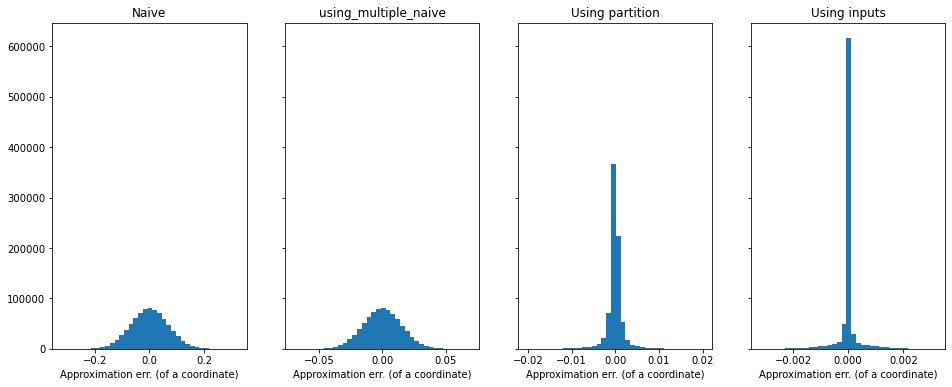

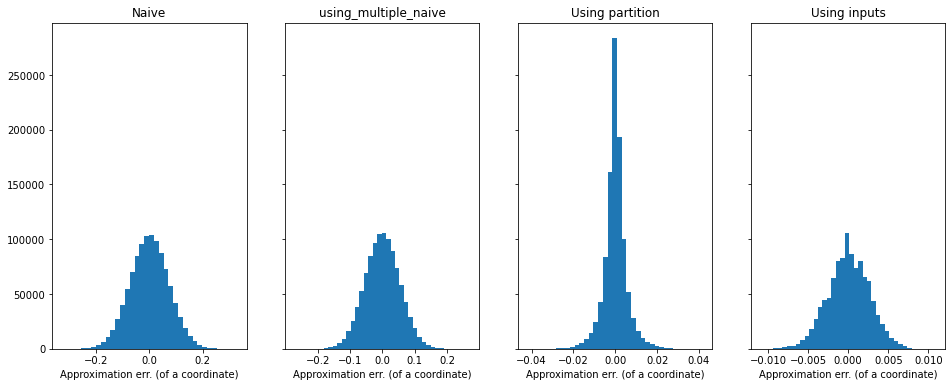

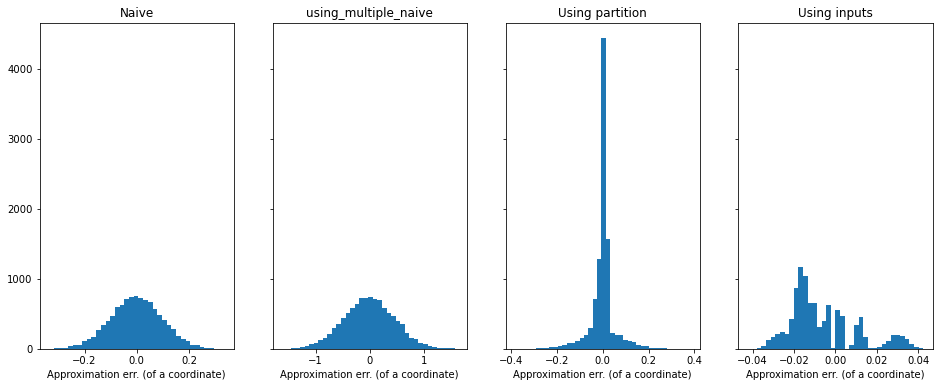

In [33]:
train_dl, valid_dl, test_dl = get_mnist_dl(device=DEVICE)

model = LeNet().to(DEVICE)
'''
for p in model.parameters():
    g = p.view(-1)
    v = torch.normal(mean = torch.full((1, len(g)), 0.), std = torch.full((1, len(g)), 0.1)).to(DEVICE)
    p.data = v.view(p.shape)
'''
    
opt = torch.optim.SGD(model.parameters(), lr=1e-4)

stats = run_experiment(model, opt, train_dl, epochs = 1)